<a href="https://colab.research.google.com/github/lk-learner/image-classification/blob/main/Clay_Ceramic_roof_top_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

image metadata:
618 rows x 910 columns x 3 bands


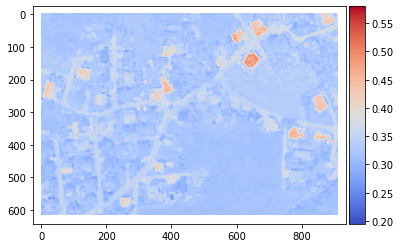

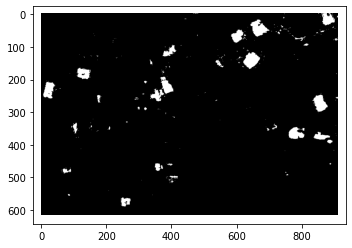

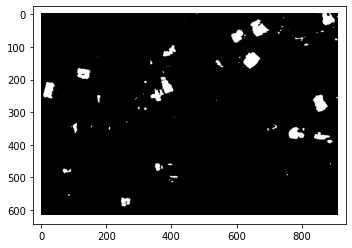

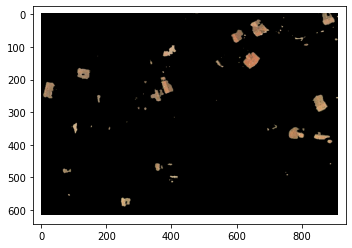

In [3]:
# Importing libraries
# To open GeoTIFF files
from osgeo import gdal
from gdalconst import *
# To create plots
import matplotlib.pyplot as plt
# To manipulate arrays
import numpy as np
# To compute mode from arrays
from scipy import stats
# To deal with colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define constants
figure_border = 25
epsilon = 0.0001
filename = "/content/drive/MyDrive/bodensee.jpg" # available at http://web.eee.sztaki.hu/remotesensing/building_benchmark.html
max_y = 100000
max_steps = 250

# Load the dataset
dataset = gdal.Open(filename, GA_ReadOnly) 

# Retrieve metadata from raster
rows = dataset.RasterYSize
columns = dataset.RasterXSize
N = rows * columns
bands = dataset.RasterCount

# Get array_RGB to display 
array_R = dataset.GetRasterBand(1).ReadAsArray()
array_G = dataset.GetRasterBand(2).ReadAsArray()
array_B = dataset.GetRasterBand(3).ReadAsArray()
array_RGB = np.zeros((rows, columns, bands), dtype=np.uint8)
array_RGB[:,:,0] = array_R
array_RGB[:,:,1] = array_G
array_RGB[:,:,2] = array_B

# Print basic metadata
print ("image metadata:")
print (rows, "rows x", columns, "columns x", bands, "bands")

# Compute the ratio for all bands.
# This array contains a band where every (r,c) pixel is the sum of pixels in (r,c) positions for all bands.
band_sums = np.zeros((rows, columns))
for b in range(1,bands+1):
	band_array = dataset.GetRasterBand(b).ReadAsArray()
	band_sums += band_array
band_sums[band_sums == 0] = epsilon
# The array of ratios is the final computation for all bands
array_of_ratios = np.zeros((rows, columns, bands))
for b in range(1,bands+1):
	band_array = dataset.GetRasterBand(b).ReadAsArray()
	array_of_ratios[:,:,b-1] = band_array / band_sums

# Create animation of threshold over histogram (must create the folder "./animation")
min_R = np.percentile(array_of_ratios[:,:,0].ravel(), 1)
max_R = np.percentile(array_of_ratios[:,:,0].ravel(), 99)
thresholds = np.linspace(min_R, max_R, max_steps)
filename_in_animation = "/content/drive/MyDrive/animation/step_"
step = 0
for threshold in thresholds:
	output_fig, (histogram_31_ax, threshold_ax) = plt.subplots(figsize = (8, 8), nrows=2)

	# Create histogram with current threshold
	title = "threshold = "+str(f'{threshold:1.5f}')
	histogram_31_ax.set_title(title)
	histogram_31_ax.hist(array_of_ratios[:,:,0].ravel(), bins=200, range=(0.0, 1.0), fc='k', ec='k')
	histogram_31_ax.bar(threshold, max_y, 0.001, fc='r')
	histogram_31_ax.set_xlim([min_R, max_R])
	histogram_31_ax.set_ylim([0, max_y])
	
	# Create plot with ratio band with threshold
	threshold_array_of_ratios = array_of_ratios[:,:,0] > threshold
	threshold_ax.imshow(threshold_array_of_ratios, cmap="gray")
	threshold_ax.set_xlim([0 - figure_border, columns + figure_border])
	threshold_ax.set_ylim([rows + figure_border, 0 - figure_border])
	plt.tight_layout()
	output_fig.savefig(filename_in_animation+str(step).zfill(6)+".png", format='png', dpi=200)
	step = step + 1
	plt.close()

# Save plot of RATIO for band 0 (red)
output_fig = plt.figure()
ratiob0_ax = output_fig.add_subplot(111)
ratiob0_img = plt.imshow(array_of_ratios[:,:,0], cmap="coolwarm")
ratiob0_ax.set_xlim([0 - figure_border, columns + figure_border])
ratiob0_ax.set_ylim([rows + figure_border, 0 - figure_border])
divider = make_axes_locatable(ratiob0_ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ratiob0_img, cax=cax0)
output_fig.savefig("ratio_b0.png", format='png', dpi=200)

# Apply found threshold and save plot
threshold = 0.38342
threshold_ratio_b0 = array_of_ratios[:,:,0] > threshold
output_fig = plt.figure()
ratiob0t_ax = output_fig.add_subplot(111)
ratiob0t_img = plt.imshow(threshold_ratio_b0, cmap="gray")
ratiob0t_ax.set_xlim([0 - figure_border, columns + figure_border])
ratiob0t_ax.set_ylim([rows + figure_border, 0 - figure_border])
output_fig.savefig("ratio_b0_threshold.png", format='png', dpi=200)

# Apply 3x3 mode filter to remove noise and save plot
mode_threshold_ratio_b0 = np.copy(threshold_ratio_b0)
for i in range(1,rows):
	for j in range(1,columns):
		values = np.array(threshold_ratio_b0[i-1:i+2, j-1:j+2])
		mode_threshold_ratio_b0[i, j] = stats.mode(values.ravel())[0][0]
output_fig = plt.figure()
ratiob0tm_ax = output_fig.add_subplot(111)
ratiob0tm_img = plt.imshow(mode_threshold_ratio_b0, cmap="gray")
ratiob0tm_ax.set_xlim([0 - figure_border, columns + figure_border])
ratiob0tm_ax.set_ylim([rows + figure_border, 0 - figure_border])
output_fig.savefig("ratio_b0_threshold_mode.png", format='png', dpi=200)

# Create final image with only rooftops and save plot
array_roofs = np.copy(array_RGB)
for b in range(bands):
	array_roofs[:,:,b] = array_roofs[:,:,b] * mode_threshold_ratio_b0
output_fig = plt.figure() #figsize = (16,9))
input_ax = output_fig.add_subplot(111)
input_ax.imshow(array_roofs)
input_ax.set_xlim([0 - figure_border, columns + figure_border])
input_ax.set_ylim([rows + figure_border, 0 - figure_border])
output_fig.savefig("array_of_roofs.png", format='png', dpi=200)

dataset = None

In [8]:
# Run ffmpeg to make video file from animation steps. Animation file will be saved to your drive.
!ffmpeg -f image2 -pattern_type glob -i "/content/drive/MyDrive/animation/*.png" -r 25 -b 50000000 -filter:v "setpts=0.5*PTS" -an animation.flv
# Rendering video file: animation.flv
from moviepy.editor import *
path="/content/animation.flv" 
clip=VideoFileClip(path)
clip.ipython_display(width=720)

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

 99%|█████████▉| 126/127 [00:04<00:00, 28.01it/s]
